<a href="https://colab.research.google.com/github/dorealex/Atipoftheiceberg/blob/master/ISED_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#pips

#imports
import numpy as np
import pandas as pd
import spacy
import re


In [54]:
#!pip install spacy
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [55]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.9) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔
package   en-core-web-md   en_core_web_md   2.1.0   ✔
link      en               en_core_web_sm   2.1.0   ✔



In [0]:
def preprocess_text(sen):
  #get rid of CCM
  sentence = re.sub(r'CCM', ' ', sen)
  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

In [0]:
df = pd.read_csv("/content/drive/My Drive/A Tip of the Iceberg/data/ised_atip_with_cols.csv")

In [0]:
y_cols = ['AEB', 'CB', 'CIPO', 'CMS',
       'DTSS', 'IC', 'IS', 'MIN', 'NONE',
       'OCS', 'OCSA', 'SBMS', 'SCMS',
       'SIPS', 'SRS', 'STS']

In [59]:
df.columns

Index(['request', 'summary text', 'correspondence', 'category', 'sectors',
       'source', 'date complete received', 'ext_search', 'ext_3rd_pty',
       'ext_conslt', 'due date', 'date closed', 'days_allowed', 'days_taken',
       'disposition', 'method of access', 'pages_review', 'pages_release',
       'consult_ogd', 'conslt_othgov', 'consult_tp', 'consult_comp_ogd',
       'consult_comp_othgov', 'consult_comp_tp', 'consult_out_ogd',
       'consult_out_othgov', 'consult_tp.1', 'AEB', 'CB', 'CIPO', 'CMS',
       'DTSS', 'IC', 'IS', 'MIN', 'NONE', 'OCS', 'OCSA', 'SBMS', 'SCMS',
       'SIPS', 'SRS', 'STS'],
      dtype='object')

In [0]:
summaries = df['summary text']

In [0]:
summaries = [preprocess_text(x) for x in summaries]

In [0]:
docs = [nlp(i) for i in summaries]

In [0]:
tokens = []
lemma = []
pos = []

for doc in nlp.pipe(df['summary text'].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
        
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        

df['summary_tokens'] = tokens
df['summary_lemma'] = lemma
df['summary_pos'] = pos


In [0]:
vecs = []
for doc in nlp.pipe(df['summary text'].astype('unicode').values, batch_size=50,
                        n_threads=3):
  vecs.append(doc.vector)

df['vecs'] = vecs


In [14]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#entities = [x.ents for x in docs]

In [0]:
#flattened = [item for sublist in entities for item in sublist]

In [0]:
X = vecs
ylabels = df[y_cols].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.20, random_state=101)

In [65]:
df[y_cols].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [0]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
punctuations = string.punctuation

In [0]:
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [0]:
parser = English()

In [0]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
vocab_size = len(nlp.vocab)
tokenizer = Tokenizer(nlp.vocab)
glove_file = open('/content/drive/My Drive/Projects/Triage/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [0]:
maxlen=300 #had to manually change this, as the dimensions were wrong... no real idea why this was done
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(16, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

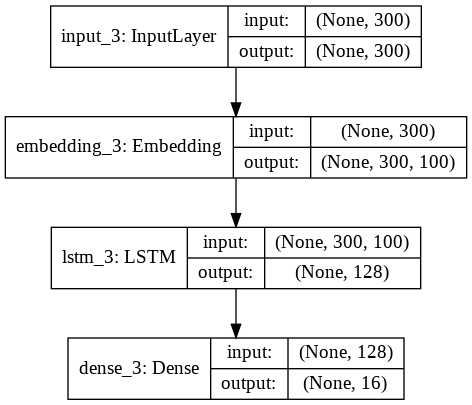

In [89]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [91]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)
checkpoint_path = "/content/drive/models"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

1.15.0


In [105]:
history = model.fit([X_train], [y_train], batch_size=50, epochs=10, verbose=1, validation_split=0.2)

Train on 1520 samples, validate on 380 samples
Epoch 1/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2706 - acc: 0.9099 - val_loss: 0.2612 - val_acc: 0.9123
Epoch 2/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2710 - acc: 0.9099 - val_loss: 0.2631 - val_acc: 0.9123
Epoch 3/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2715 - acc: 0.9099 - val_loss: 0.2614 - val_acc: 0.9123
Epoch 4/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2706 - acc: 0.9099 - val_loss: 0.2629 - val_acc: 0.9123
Epoch 5/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2707 - acc: 0.9099 - val_loss: 0.2617 - val_acc: 0.9123
Epoch 6/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2706 - acc: 0.9099 - val_loss: 0.2612 - val_acc: 0.9123
Epoch 7/10
1520/1520 [==============================] - 13s 9ms/step - loss: 0.2706 - acc: 0.9099 - val_loss: 0.2642 - val_acc: 0.9123
Epoch 8/

In [0]:
model.save_weights("/content/drive/My Drive/models/model.h5")

In [0]:
model_json = model.to_json()
with open("/content/drive/My Drive/models/model.json", "w") as json_file:
    json_file.write(model_json)

In [108]:
score = model.evaluate([X_test], [y_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

475/475 [==============================] - 2s 5ms/step
Test Score: 0.2592602763050481
Test Accuracy: 0.9138157911049692


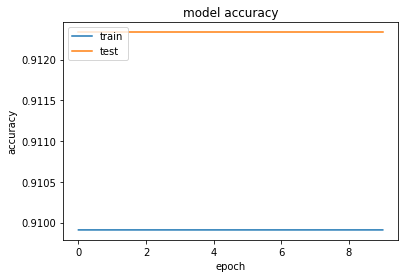

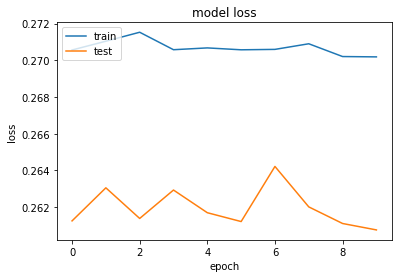

In [111]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [126]:
len(X_train)

1900

In [127]:
X_train

[array([-1.07943945e-01,  2.42559969e-01, -8.25356767e-02, -3.56931947e-02,
        -8.97369385e-02,  8.17905553e-03,  6.36703894e-02, -6.53379932e-02,
         6.98577985e-02,  1.50311387e+00, -3.74218911e-01,  5.40721640e-02,
         1.90652143e-02,  3.52769089e-03, -2.49901004e-02,  2.80140042e-02,
        -1.58288106e-01,  1.10461271e+00, -6.13680631e-02,  6.62192777e-02,
         4.54665013e-02,  1.54063068e-02, -3.10824420e-02,  4.67905588e-03,
         7.00731650e-02,  1.20669283e-01,  4.53327922e-03,  1.99170299e-02,
         8.19896758e-02,  6.61416650e-02,  3.10270283e-02,  1.19391836e-01,
         1.54003859e-01, -5.25573082e-02,  3.53514291e-02,  1.48264430e-02,
        -7.50857145e-02,  6.55309558e-02, -1.33534968e-01,  2.42435541e-02,
         1.43925529e-02,  3.84261049e-02, -1.10368162e-01,  3.63944247e-02,
         1.11958943e-02, -7.67527288e-03, -2.04541050e-02,  1.60104871e-01,
         2.49682609e-02,  6.06487319e-02, -5.28310016e-02, -5.97326308e-02,
         2.0